# Texture Based Feature Extraction and Unsupervised Semantic Segmentation

By Peyman Hashemi

Dec 2022


## Part 1: GLCM-Based Feature Extraction and Semantic Segmentation

## Imports

In [2]:
import time

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(); sns.set_style('dark')
from matplotlib import colors

import cv2
import numpy as np

from skimage.transform import resize
from skimage.util.shape import view_as_windows
from skimage.feature import graycomatrix, graycoprops

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from joblib import Parallel, delayed

## Functions

In [3]:
def rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def bgr(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

def gray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def disp(img, title='', s=8, vmin=None, vmax=None):
    plt.figure(figsize=(s,s))
    plt.axis('off')
    if vmin is not None and vmax is not None:
        plt.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
    else:
        plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.show()

def uint8ify(img):
    img -= img.min()
    img /= img.max()
    img *= 255
    return np.uint8(img)

def overlay(a,b):
    # a and b should be float images and between 0-1

    mask = a >= 0.5 # generate boolean mask of everywhere a > 0.5 
    ab = np.zeros_like(a) # generate an output container for the blended image 

    # now do the blending 
    ab[~mask] = (2*a*b)[~mask] # 2ab everywhere a<0.5
    ab[mask] = (1-2*(1-a)*(1-b))[mask] # else this
    
    return ab

def before_after(img_a, img_b, name='', vmin=None, vmax=None, effect_name='Processed'):
    fig, axs = plt.subplots(1,2, constrained_layout=True, figsize=(10,4))
    axs[0].axis('off')
    axs[1].axis('off')
    axs[0].set_title(f'{name} Original')
    axs[1].set_title(f'{name} {effect_name}')
    if vmin is not None and vmax is not None:
        axs[0].imshow(img_a, cmap='gray', vmin=vmin, vmax=vmax)
        axs[1].imshow(img_b, cmap='gray', vmin=vmin, vmax=vmax)
    else:
        axs[0].imshow(img_a, cmap='gray')
        axs[1].imshow(img_b, cmap='gray')
    plt.show()

## Load Images

In [4]:
def downsample(img, factor=2):
    return resize(img, (img.shape[0]//factor, img.shape[1]//factor), anti_aliasing=True)

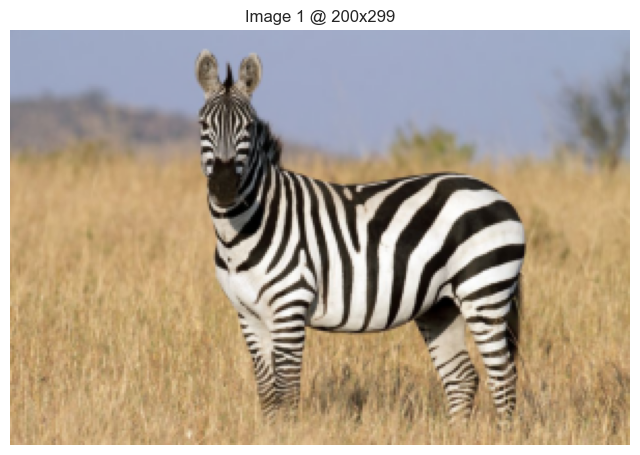

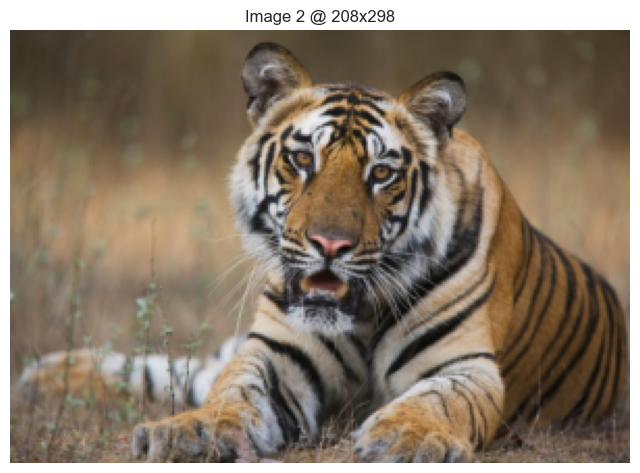

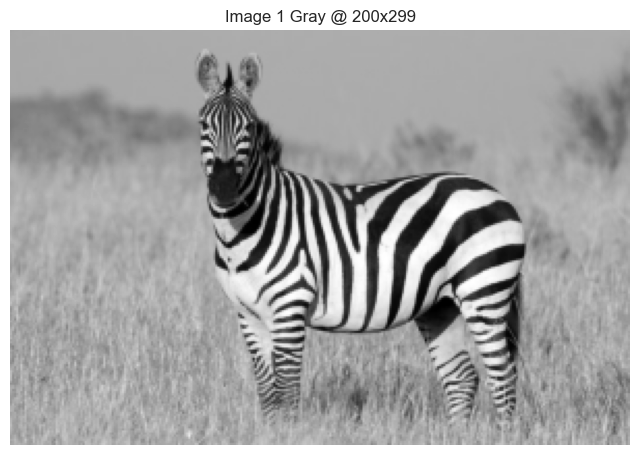

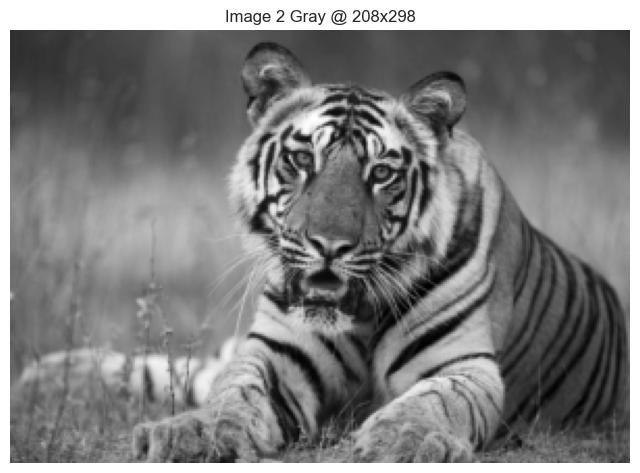

In [5]:
img1 = (downsample(rgb(cv2.imread('data\img1.jpg')), factor=10/3)*255).astype(np.uint8)
img1_gray = gray(img1)
img2 = (downsample(rgb(cv2.imread('data\img2.jpg')), factor=10/3.2)*255).astype(np.uint8)
img2_gray = gray(img2)

disp(img1, f'Image 1 @ {img1.shape[0]}x{img1.shape[1]}')
disp(img2, f'Image 2 @ {img2.shape[0]}x{img2.shape[1]}')

disp(img1_gray, f'Image 1 Gray @ {img1_gray.shape[0]}x{img1_gray.shape[1]}')
disp(img2_gray, f'Image 2 Gray @ {img2_gray.shape[0]}x{img2_gray.shape[1]}')

## GLCM Features

### get patches

In [6]:
def get_patches(img, patch_size=9, step_size=1, grayscale_levels=100):
    # reduce the number of levels in the image
    img = img.astype(np.float32)
    img = (img / 255.0 * grayscale_levels).astype(np.uint8)
    patches = view_as_windows(img, (patch_size, patch_size), step=step_size)
    return patches

def show_random_patches(patches, title='', grayscale_levels=255):
    fig, axs = plt.subplots(3, 3, constrained_layout=True, figsize=(8,8))
    fig.suptitle(title)
    for i in range(3):
        for j in range(3):
            patch = patches[np.random.randint(patches.shape[0]), np.random.randint(patches.shape[1])]
            axs[i,j].axis('off')
            axs[i,j].imshow(patch, cmap='gray', vmin=0, vmax=int(grayscale_levels))
            if i==1 and j==1:
                print(patch.min(), patch.max())
    plt.show()

11 244


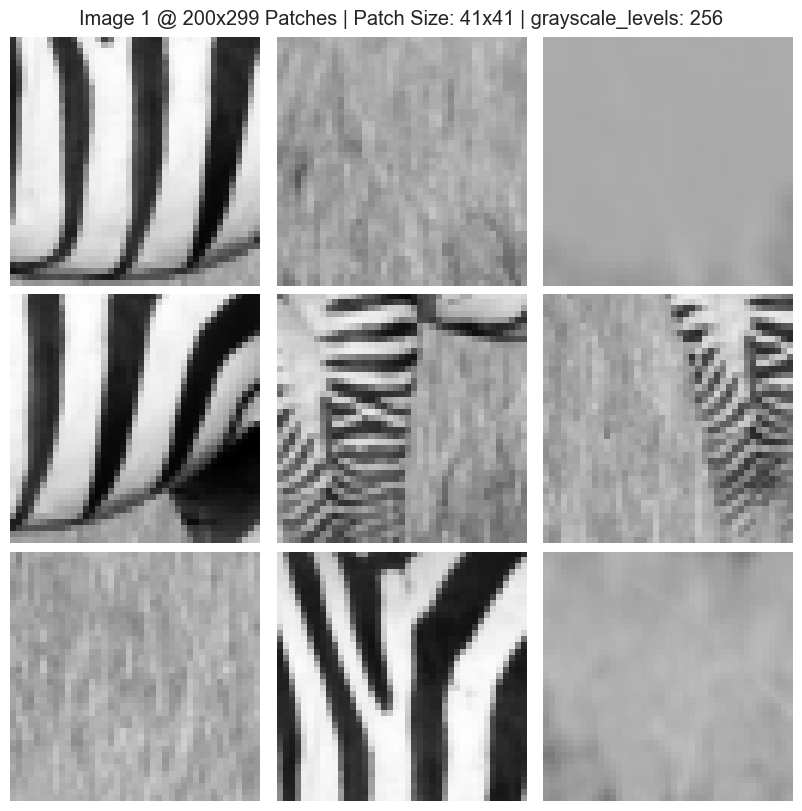

In [7]:
np.random.seed(3)
patches = get_patches(img1_gray, patch_size=41, step_size=1, grayscale_levels=255)
show_random_patches(patches, title=f"Image 1 @ {img1_gray.shape[0]}x{img1_gray.shape[1]} Patches | Patch Size: 41x41 | grayscale_levels: 256")

In [8]:
np.random.seed(0)

### GLCM Feature Extraction

In [9]:
def get_glcm_features(patches, levels=256, n_features=4):
    # GLCM features
    features = np.zeros((patches.shape[0], patches.shape[1], n_features))

    # Loop over patches
    start_time = time.time()
    for i in range(patches.shape[0]):
        time_elapsed = time.time() - start_time
        predicted_time = time_elapsed / (i+1) * patches.shape[0] - time_elapsed
        print(f'Processing row {i+1}/{patches.shape[0]} | Time Elapsed: {time_elapsed:.2f} secs | Time remaining: {predicted_time:.2f} secs', end='\r')
        for j in range(patches.shape[1]):
            glcm = graycomatrix(patches[i,j].copy(), [1], [0], levels=levels, symmetric=True, normed=True)

            features[i,j,0] = graycoprops(glcm, 'dissimilarity')[0, 0]
            if n_features == 1:
                continue
            
            features[i,j,1] = graycoprops(glcm, 'correlation')[0, 0]
            if n_features == 2:
                continue

            features[i,j,2] = graycoprops(glcm, 'contrast')[0, 0]
            if n_features == 3:
                continue

            features[i,j,3] = graycoprops(glcm, 'homogeneity')[0, 0]
            if n_features == 4:
                continue

            features[i,j,4] = graycoprops(glcm, 'ASM')[0, 0]
            if n_features == 5:
                continue

            features[i,j,5] = graycoprops(glcm, 'energy')[0, 0]
            if n_features > 6:
                raise ValueError('Too many features requested')
    return features

In [10]:
def get_glcm_features_parallel(patches, levels=256, metrics=["dissimilarity", "correlation", "contrast", "homogeneity", "ASM", "energy"], distances = [1, 3, 5], angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]):
    # GLCM features
    n_features = len(metrics)
    distances = [1, 3, 5]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    full_features = np.zeros((patches.shape[0], patches.shape[1], n_features*(len(angles)*len(distances))))

    def extract_features(patch):
        glcm = graycomatrix(patch.copy(), distances, angles, levels=levels, symmetric=True, normed=True)
        features = np.zeros(n_features*(len(angles)*len(distances)))
        for i, metric in enumerate(metrics):
            for j, angle in enumerate(angles):
                for k, distance in enumerate(distances):
                    features[i*(len(angles)*len(distances))+j*len(distances)+k] = graycoprops(glcm, metric)[k, j]

        return features

    # Loop over patches in parallel
    nprocs = 10
    result = []
    result.extend(Parallel(n_jobs=nprocs)(delayed(extract_features)(patches[i,j]) for i in range(patches.shape[0]) for j in range(patches.shape[1])))
    result = np.array(result)
    full_features = result.reshape(patches.shape[0], patches.shape[1], n_features*(len(angles)*len(distances)))

    return full_features

### def segment_image_glcm( )

In [11]:
def segment_image_glcm(img, levels=50, patch_size=41, metrics=["dissimilarity"], distances = [1], angles = [0], random_state=2, n_clusters=2, debug=True):
    # One patch per pixel
    patches = get_patches(img, patch_size=patch_size, step_size=1, grayscale_levels=levels)
    features = get_glcm_features_parallel(patches, levels=levels, metrics=metrics, distances = distances, angles = angles)

    # Normalize features
    scaler = StandardScaler().fit(features.reshape(-1, features.shape[-1]))
    normalized_data = scaler.transform(features.reshape(-1, features.shape[-1]))

    # Cluster features
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state).fit(normalized_data)
    labels = kmeans.labels_.reshape(features.shape[:2])

    # Make a color map of fixed colors
    if n_clusters == 3:
        cmap = colors.ListedColormap([[10/255, 10/255, 10/255], [128/255, 64/255, 128/255], [102/255, 102/255, 156/255]])
        bounds=[0,1,2,3]
    elif n_clusters == 2:
        cmap = colors.ListedColormap([[128/255, 64/255, 128/255], [102/255, 102/255, 156/255]])
        bounds=[0,1,2]

    norm = colors.BoundaryNorm(bounds, cmap.N)

    # plot labels
    if debug:
        fig, ax = plt.subplots(1, 2, figsize=(12, 10), constrained_layout=True)
        ax[0].imshow(img, cmap='gray')
        ax[0].set_title('Gray image')
        ax[0].set_axis_off()

        ax[1].imshow(labels, cmap=cmap, norm=norm)
        ax[1].set_title('Segmented image')
        ax[1].set_axis_off()
        plt.show()

### Zebra

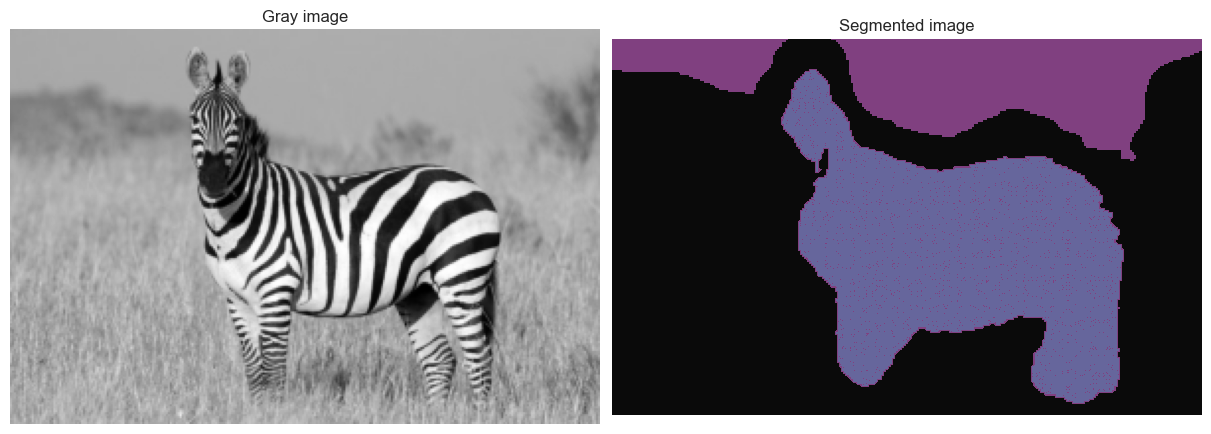

In [13]:
features = segment_image_glcm(img1_gray, levels=26, patch_size=27, metrics=["dissimilarity", "correlation", "contrast", "energy"], distances = [1], angles = [0, np.pi/4, np.pi/2, 3*np.pi/4, 4*np.pi/4, 5*np.pi/4,6*np.pi/4,7*np.pi/4], random_state=2, n_clusters=3, debug=True)

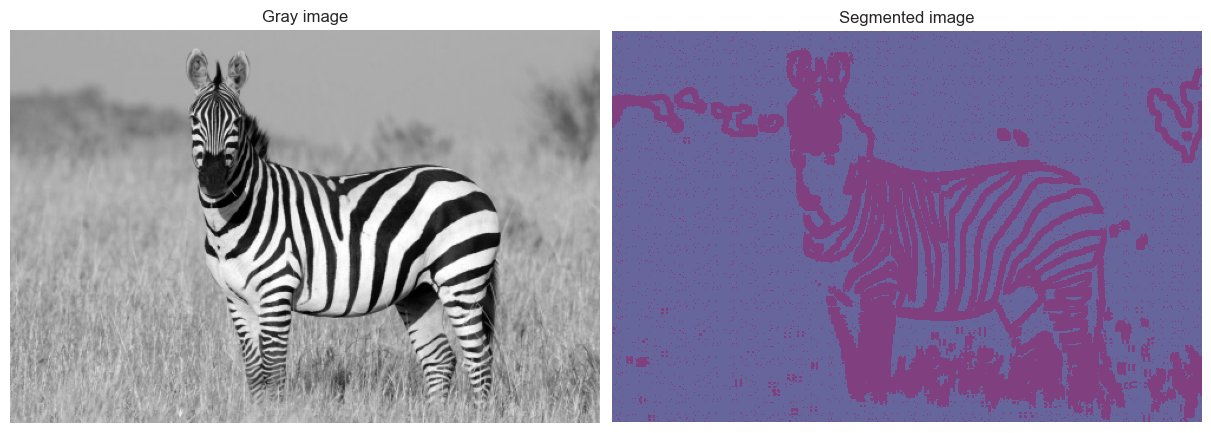

Wall time: 12.9 s


In [177]:
%%time
segment_image_glcm(img1_gray, levels=2, patch_size=5, metrics=["dissimilarity"], distances = [1], angles = [0], random_state=2, debug=True)

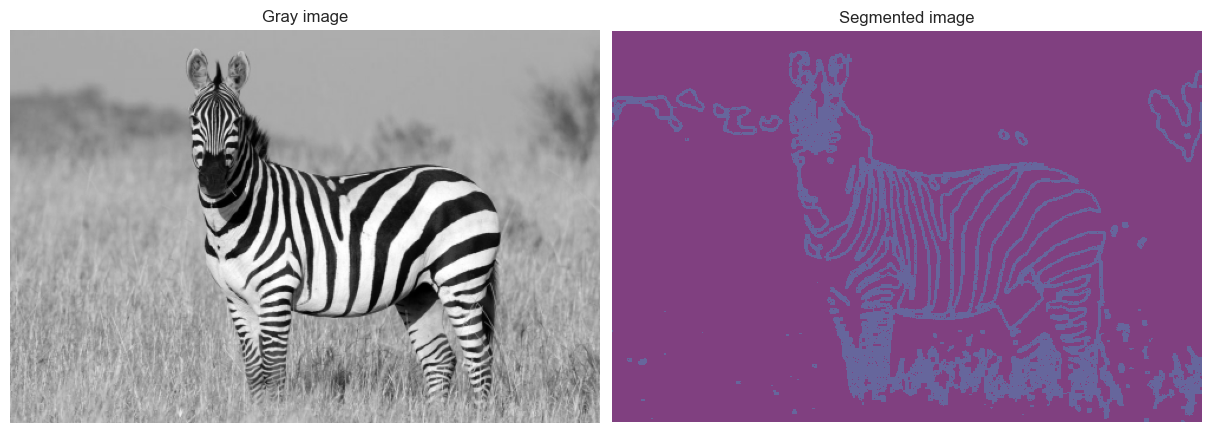

Wall time: 10.2 s


In [179]:
%%time
segment_image_glcm(img1_gray, levels=2, patch_size=5, metrics=["ASM"], distances = [1], angles = [0], random_state=2, debug=True)

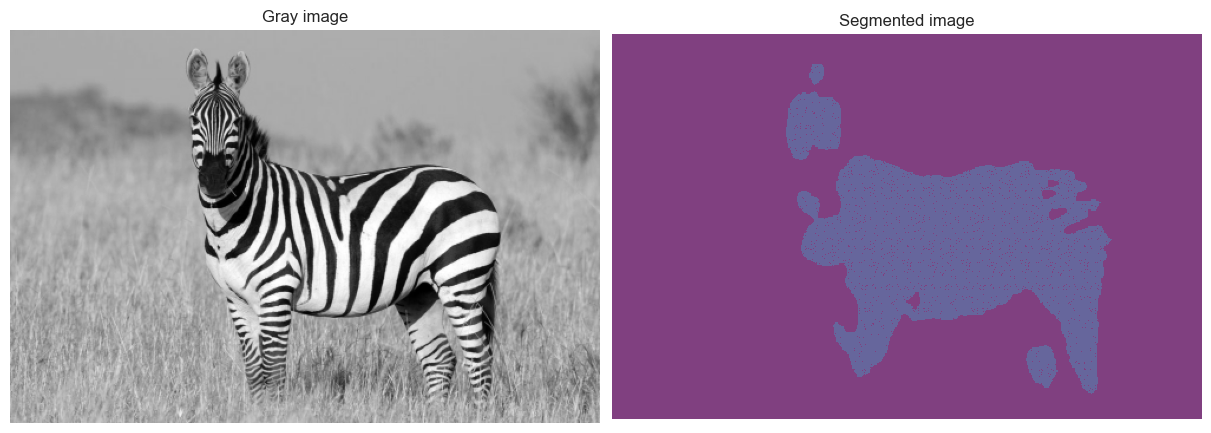

Wall time: 17.1 s


In [182]:
%%time
segment_image_glcm(img1_gray, levels=20, patch_size=21, metrics=["contrast"], distances = [1,5], angles = [0, np.pi/2], random_state=2, debug=True)

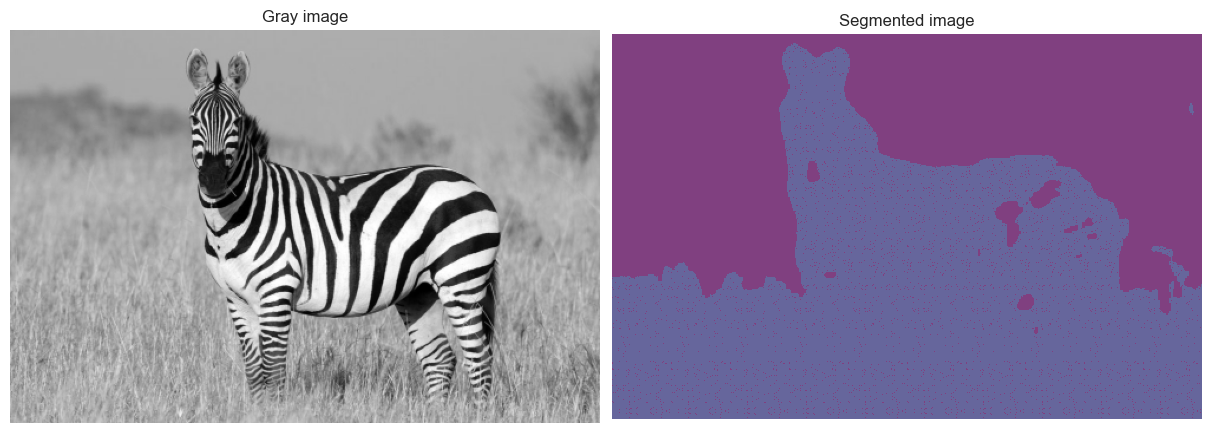

Wall time: 18.9 s


In [191]:
%%time
segment_image_glcm(img1_gray, levels=20, patch_size=21, metrics=["homogeneity"], distances = [1,5], angles = [0, np.pi/2], random_state=2, debug=True)

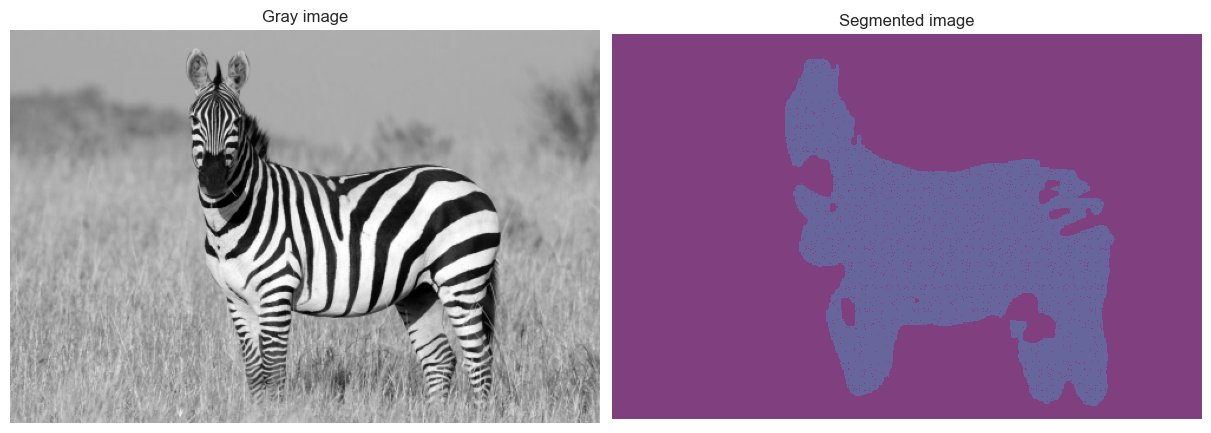

Wall time: 18.7 s


In [192]:
%%time
segment_image_glcm(img1_gray, levels=20, patch_size=21, metrics=["dissimilarity"], distances = [1,5], angles = [0, np.pi/2], random_state=2, debug=True)

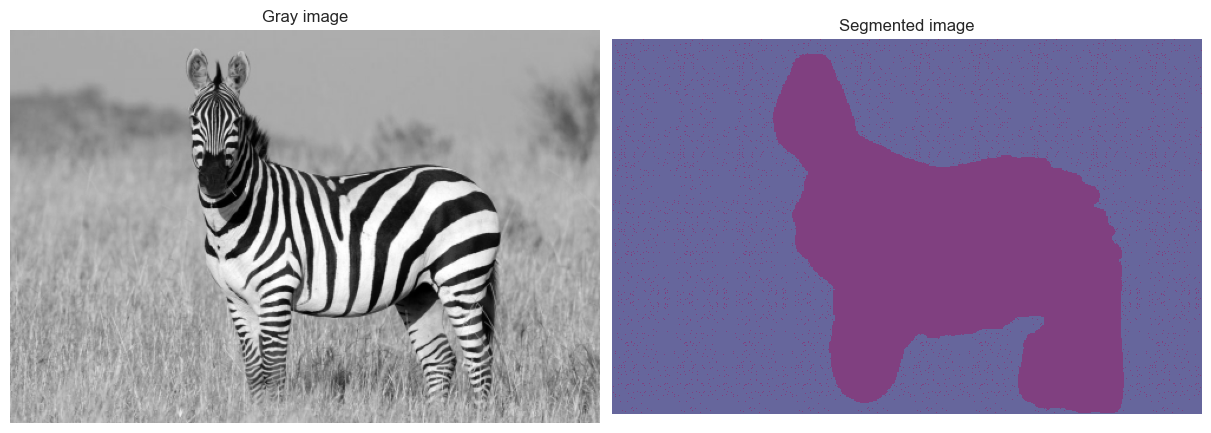

Wall time: 17.3 s


In [196]:
%%time
segment_image_glcm(img1_gray, levels=20, patch_size=41, metrics=["dissimilarity"], distances = [1,5], angles = [0, np.pi/2], random_state=2, debug=True)

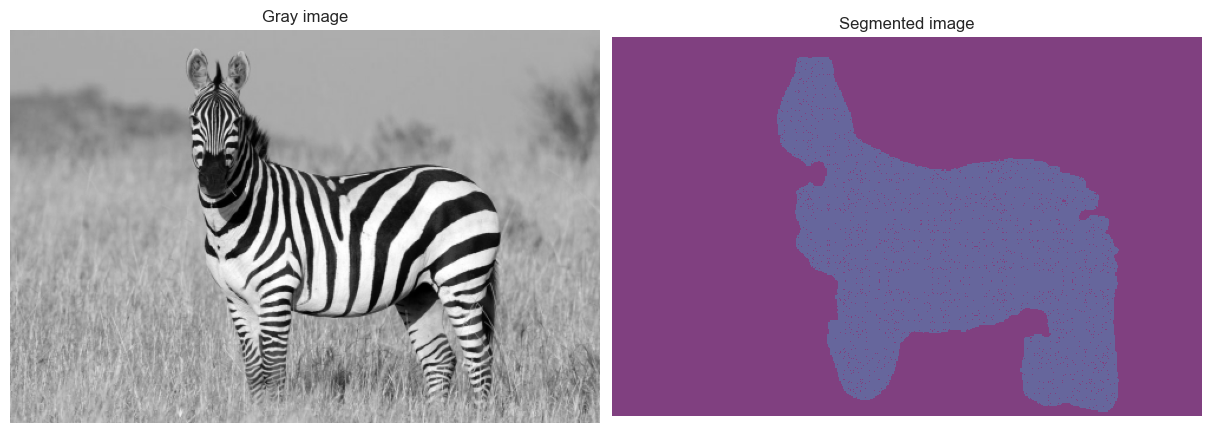

Wall time: 16.9 s


In [201]:
%%time
segment_image_glcm(img1_gray, levels=20, patch_size=35, metrics=["dissimilarity"], distances = [1,5], angles = [0, np.pi/2], random_state=2, debug=True)

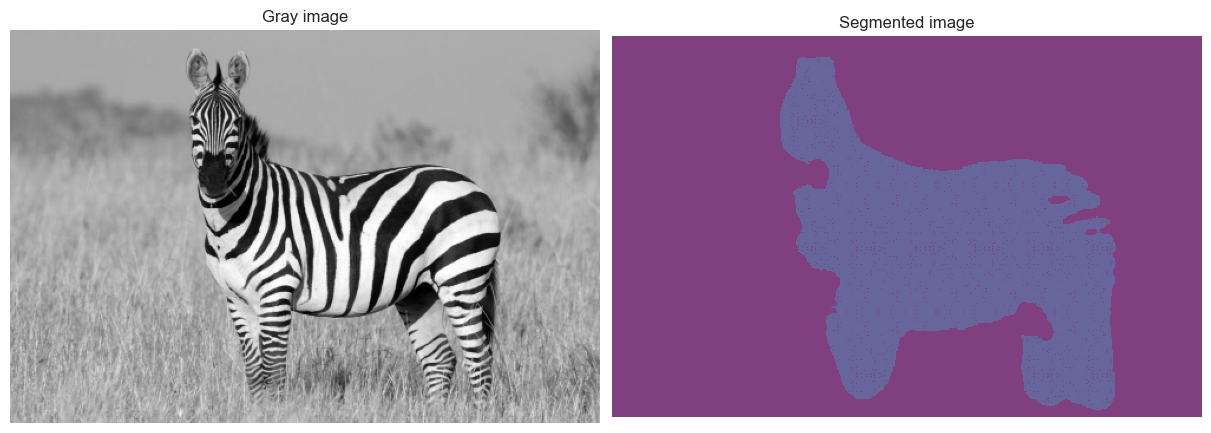

Wall time: 17.3 s


In [197]:
%%time
segment_image_glcm(img1_gray, levels=20, patch_size=31, metrics=["dissimilarity"], distances = [1,5], angles = [0, np.pi/2], random_state=2, debug=True)

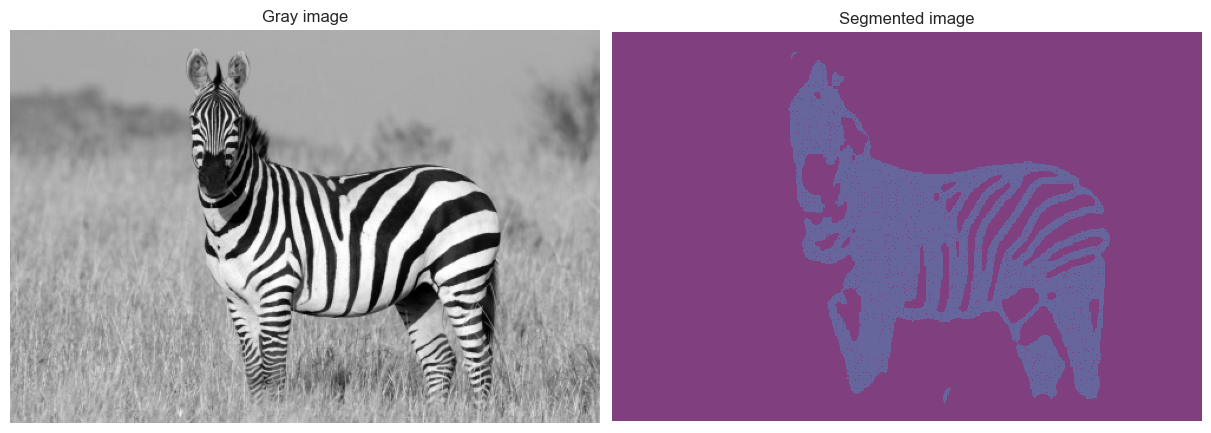

Wall time: 18.6 s


In [198]:
%%time
segment_image_glcm(img1_gray, levels=20, patch_size=11, metrics=["dissimilarity"], distances = [1,5], angles = [0, np.pi/2], random_state=2, debug=True)

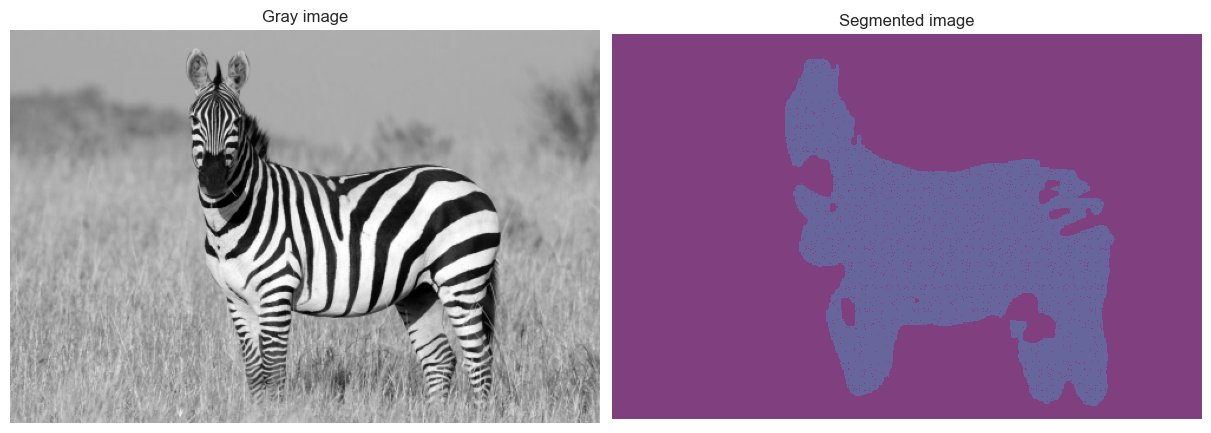

Wall time: 19 s


In [202]:
%%time
segment_image_glcm(img1_gray, levels=20, patch_size=21, metrics=["dissimilarity"], distances = [5,9,15], angles = [0, np.pi/4, np.pi/2, 3*np.pi/4], random_state=2, debug=True)

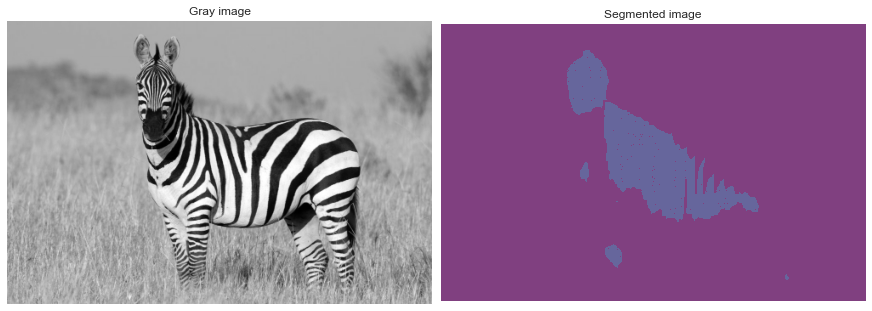

In [209]:
%%time
segment_image_glcm(img1_gray, levels=30, patch_size=21, n_features=6, random_state=2, debug=True)


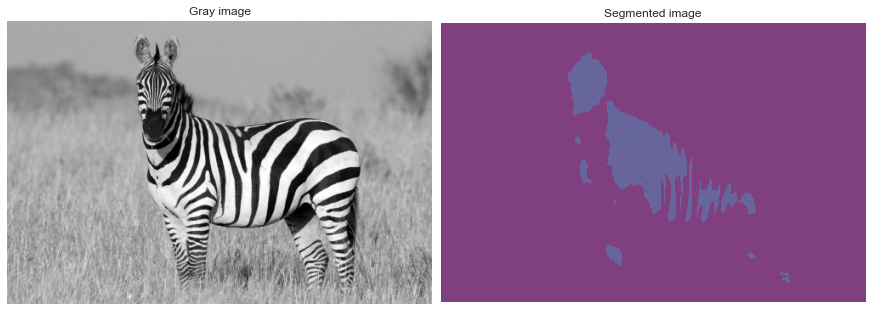

In [210]:
%%time
segment_image_glcm(img1_gray, levels=40, patch_size=15, n_features=3, random_state=2, debug=True)


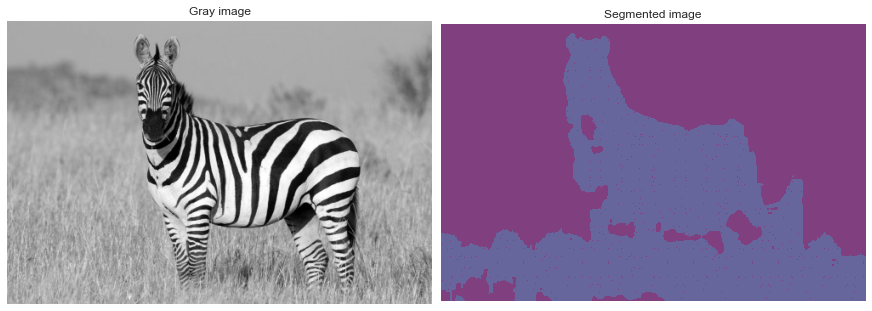

In [203]:
%%time
segment_image_glcm(img1_gray, levels=80, patch_size=21, n_features=2, random_state=2, debug=True)


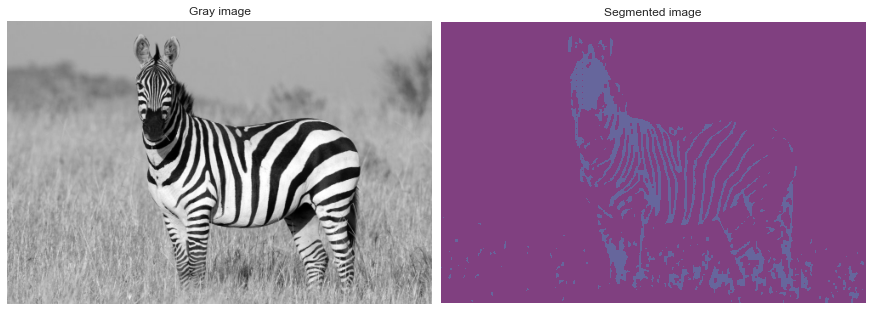

In [202]:
%%time
segment_image_glcm(img1_gray, levels=20, patch_size=5, n_features=2, random_state=2, debug=True)


In [ ]:
%%time
segment_image_glcm(img1_gray, levels=50, patch_size=71, n_features=2, random_state=2, debug=True)


### Tiger

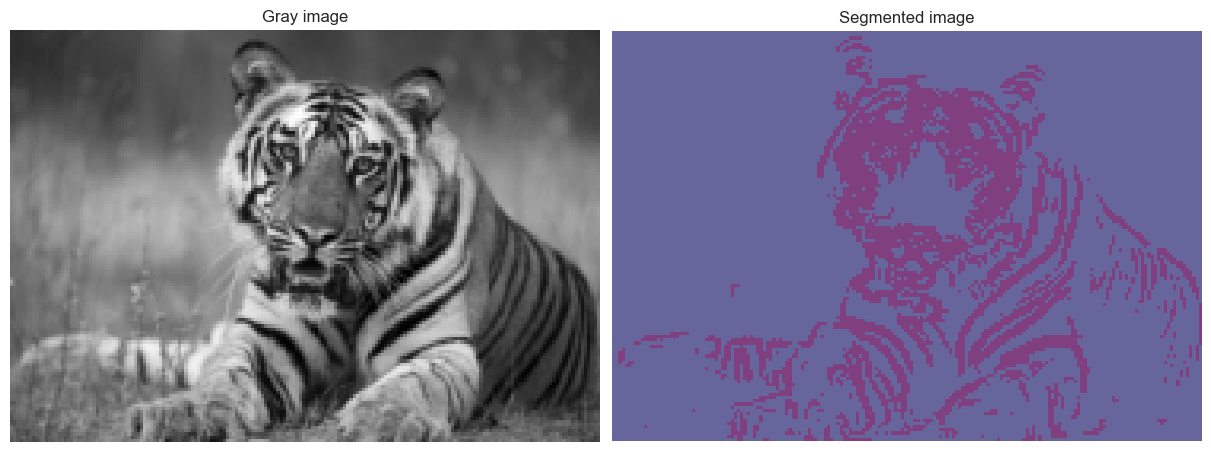

Wall time: 9.38 s


In [204]:
%%time
segment_image_glcm(img2_gray, levels=50, patch_size=3, metrics=["dissimilarity"], distances = [1,3,5], angles = [0, np.pi/4, np.pi/2, 3*np.pi/4], random_state=3, debug=True)


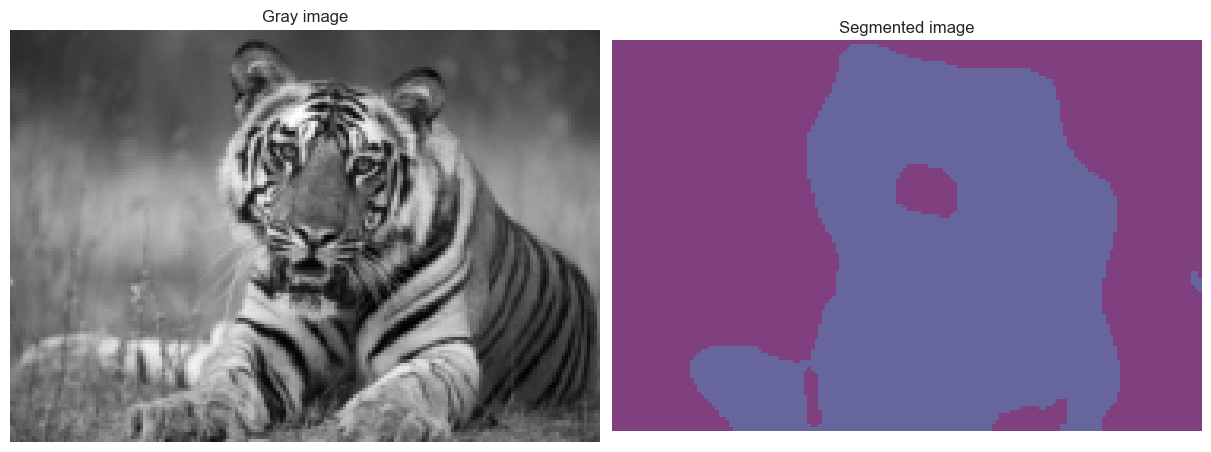

Wall time: 6.67 s


In [212]:
%%time
segment_image_glcm(img2_gray, levels=50, patch_size=21, metrics=["dissimilarity"], distances = [1], angles = [0, np.pi/4, np.pi/2, 3*np.pi/4], random_state=3, debug=True)


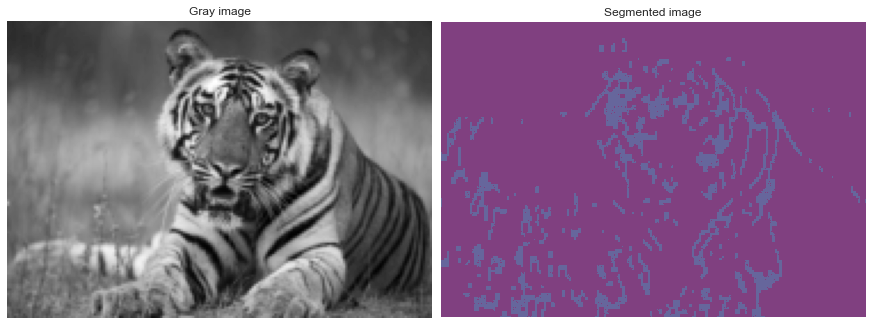

In [220]:
%%time
segment_image_glcm(img2_gray, levels=2, patch_size=3, n_features=2, random_state=2, debug=True)


## Part 2: Gabor Filter-Based Feature Extraction and Semantic Segmentation

### Gabor Filter Bank
sigma σ – Standard Deviation – Property of our bell curve. Smaller values emphasize values closer to the center

theta θ – Direction – Identifies direction of our sine wave

lambda λ – Wavelength – Distance between peaks in our sine wave

gamma γ – Ellipticity – Determines how elliptic our 2D bell curve is

psi φ – Offset – Defines the phase offset of our sine wave


In [5]:
def gabor_filter_bank(scales=5, angles=8, ksize=35, lambd=10, gamma=0.5, psi=0):
    filters = np.zeros((scales, angles, ksize, ksize))

    for i, sigma in enumerate(np.linspace(ksize/30, ksize/15, scales)):
        for j, theta in enumerate(np.arange(0, np.pi, np.pi / angles)):  # Theta is the orientation for edge detection
            kern = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_64F)
            kern /= 1.0 * kern.sum()  # Brightness normalization
            filters[i, j, :, :] = kern
    return filters

def show_gabor_filters(scales=5, angles=8, ksize=35, lambd=10, gamma=0.5, psi=0):
    filters = gabor_filter_bank(scales, angles, ksize, lambd, gamma, psi)
    fig, ax = plt.subplots(scales, angles, figsize=(10, 6), constrained_layout=True)
    for i in range(scales):
        for j in range(angles):
            ax[i, j].imshow(filters[i, j, :, :], cmap='gray')
            ax[i, j].set_axis_off()
    plt.show()

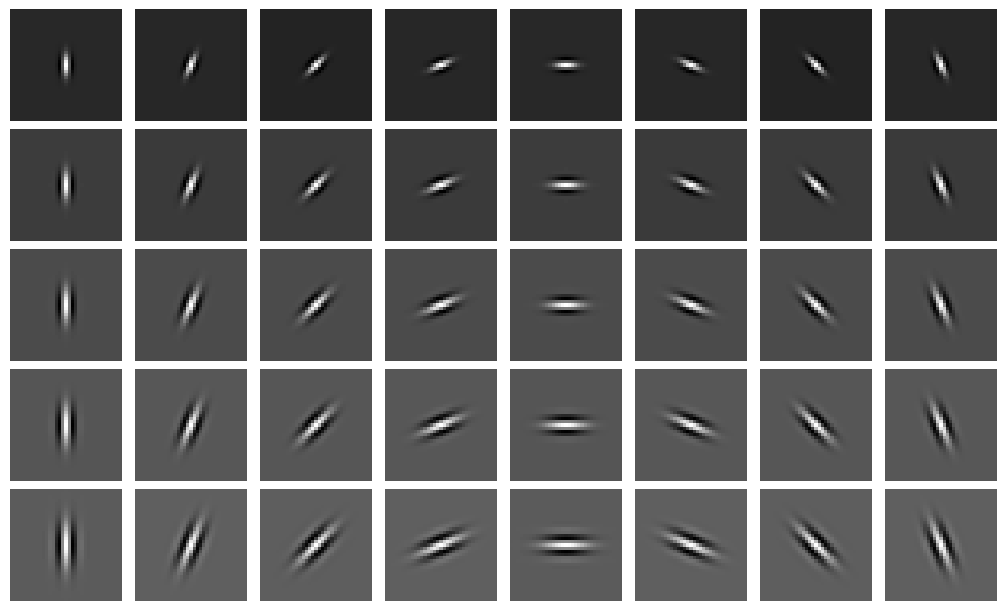

In [29]:
show_gabor_filters(scales=5, angles=8, ksize=35, lambd=5, gamma=0.5, psi=0)

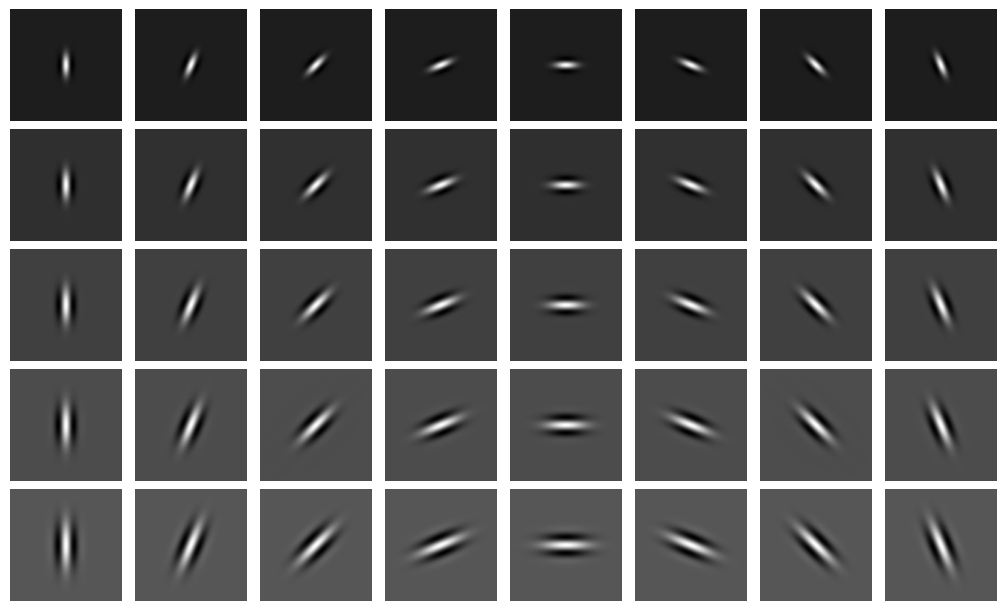

In [134]:
show_gabor_filters(scales=5, angles=8, ksize=151, lambd=25, gamma=0.5, psi=0)

### Gabor feature extraction

In [7]:
def gabor_feature_extraction(img, filters):
    features = np.zeros((filters.shape[0], filters.shape[1], img.shape[0], img.shape[1]))
    for i in range(filters.shape[0]):
        for j in range(filters.shape[1]):
            features[i, j, :, :] = cv2.filter2D(img, cv2.CV_8UC3, filters[i, j, :, :])
    return features
    

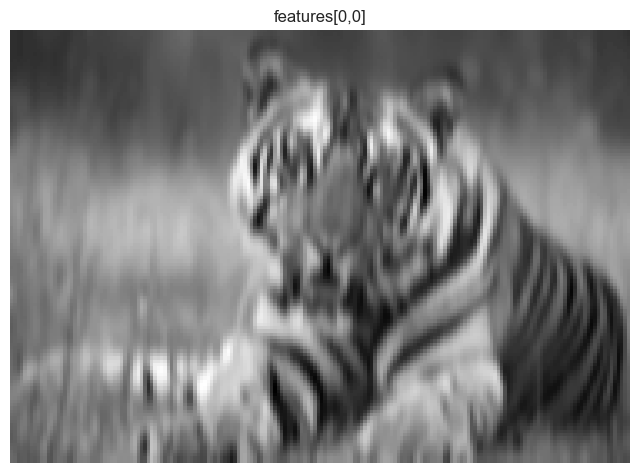

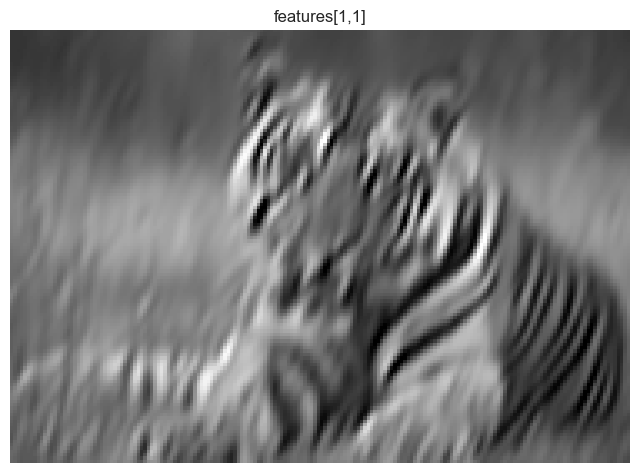

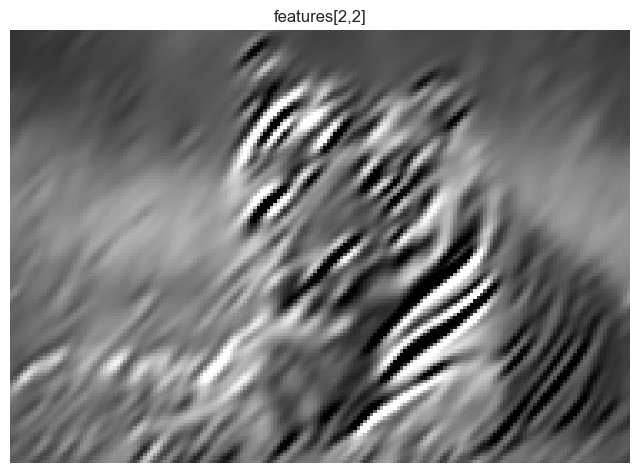

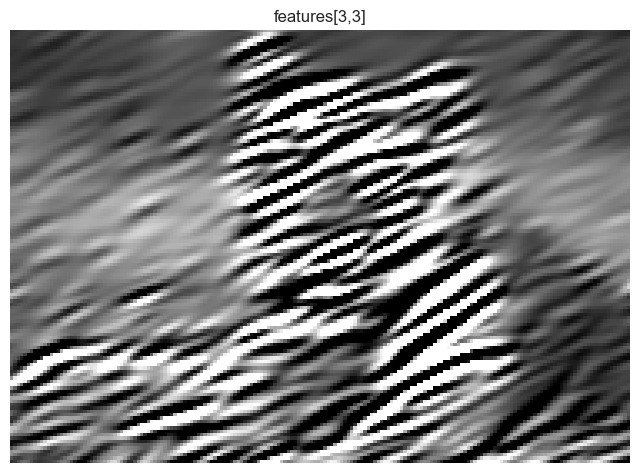

In [8]:
features = gabor_feature_extraction(img2_gray, gabor_filter_bank(scales=5, angles=8, ksize=35, lambd=5, gamma=0.5, psi=0))
disp(features[0,0], "features[0,0]")
disp(features[1,1], "features[1,1]")
disp(features[2,2], "features[2,2]")
disp(features[4,3], "features[3,3]")

### def segment_image_gabor( )

In [23]:
def segment_image_gabor(img, scales=5, angles=8, ksize=35, lambd=5, gamma=0.5, psi=0, n_clusters=2, random_state=2, debug=True):
    # One patch per pixel
    features = gabor_feature_extraction(img, gabor_filter_bank(scales, angles, ksize, lambd, gamma, psi))

    # Cluster features
    print(features.shape)
    X = features.transpose(2, 3, 0, 1) # (scales,angles,height,width) -> (height,width,scales,angles)
    X = X.reshape(-1, scales*angles) # (height,width,scales,angles) -> (height*width,scales*angles)
    print(X.shape)
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state).fit(X)
    labels = kmeans.labels_.reshape(img.shape[:2])

    # Show clustering result


    # plot labels
    if debug:
        # Make a color map of fixed colors
        if n_clusters == 3:
            cmap = colors.ListedColormap([[70/255, 70/255, 70/255], [128/255, 64/255, 128/255], [102/255, 102/255, 156/255]])
            bounds=[0,1,2,3]
        elif n_clusters == 2:
            cmap = colors.ListedColormap([[128/255, 64/255, 128/255], [102/255, 102/255, 156/255]])
            bounds=[0,1,2]
        elif n_clusters == 4:
            cmap = colors.ListedColormap([[10/255, 10/255, 10/255], [128/255, 64/255, 128/255], [102/255, 102/255, 156/255], [0/255, 0/255, 0/255]])
            bounds=[0,1,2,3,4]
        elif n_clusters == 5:
            cmap = colors.ListedColormap([[10/255, 10/255, 10/255], [128/255, 64/255, 128/255], [102/255, 102/255, 156/255], [0/255, 0/255, 0/255], [255/255, 255/255, 255/255]])
            bounds=[0,1,2,3,4,5]

        norm = colors.BoundaryNorm(bounds, cmap.N)
        
        fig, ax = plt.subplots(1, 2, figsize=(12, 10), constrained_layout=True)
        ax[0].imshow(img, cmap='gray')
        ax[0].set_title('Gray image')
        ax[0].set_axis_off()

        ax[1].imshow(labels, cmap=cmap, norm=norm)
        ax[1].set_title('Segmented image')
        ax[1].set_axis_off()
        plt.show()

### Zebra

(5, 8, 333, 500)
(166500, 40)


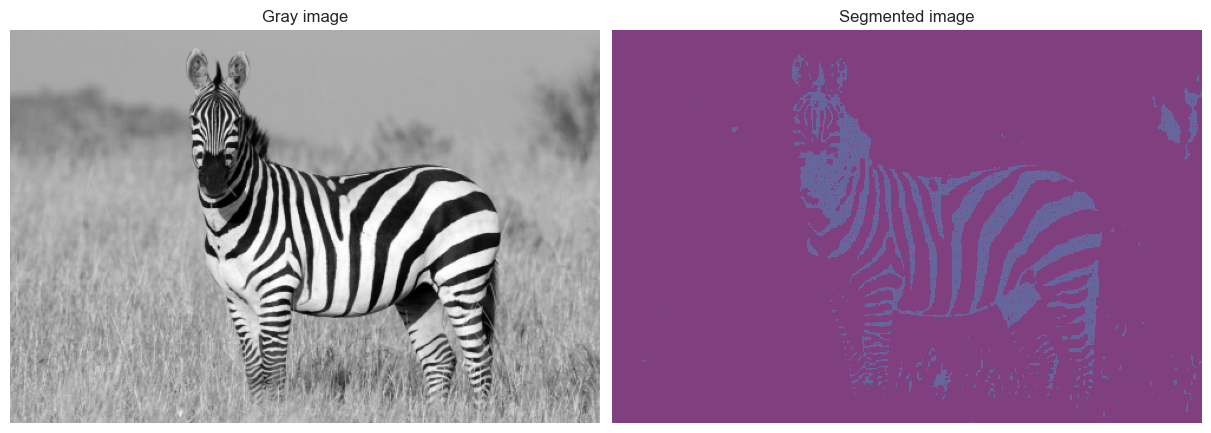

Wall time: 923 ms


In [25]:
%%time
segment_image_gabor(img1_gray, scales=5, angles=8, ksize=35, lambd=5, gamma=0.5, psi=0, n_clusters=2, random_state=2, debug=True)

(5, 8, 333, 500)
(166500, 40)


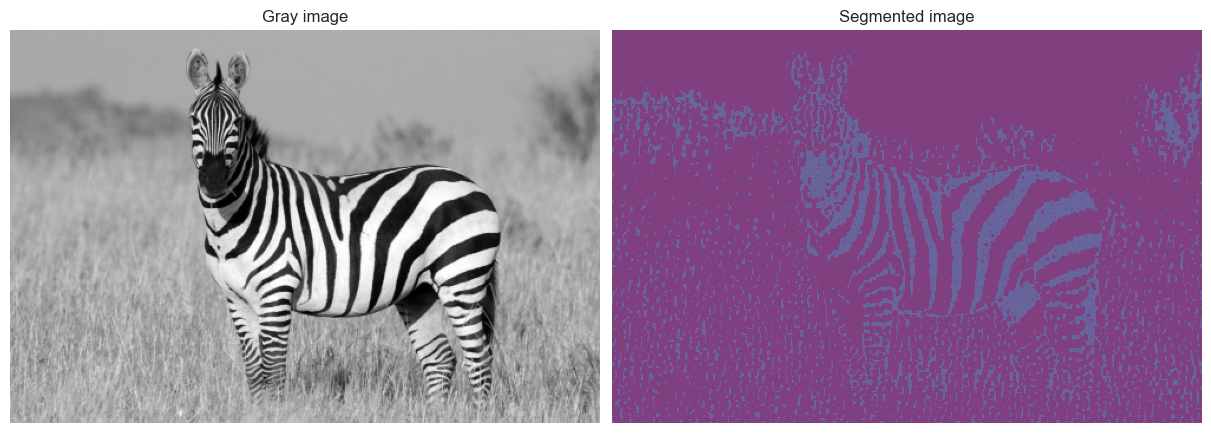

Wall time: 1.3 s


In [139]:
%%time
segment_image_gabor(img1_gray, scales=5, angles=8, ksize=51, lambd=5, gamma=0.5, psi=0, n_clusters=2, random_state=2, debug=True)


(5, 8, 333, 500)
(166500, 40)


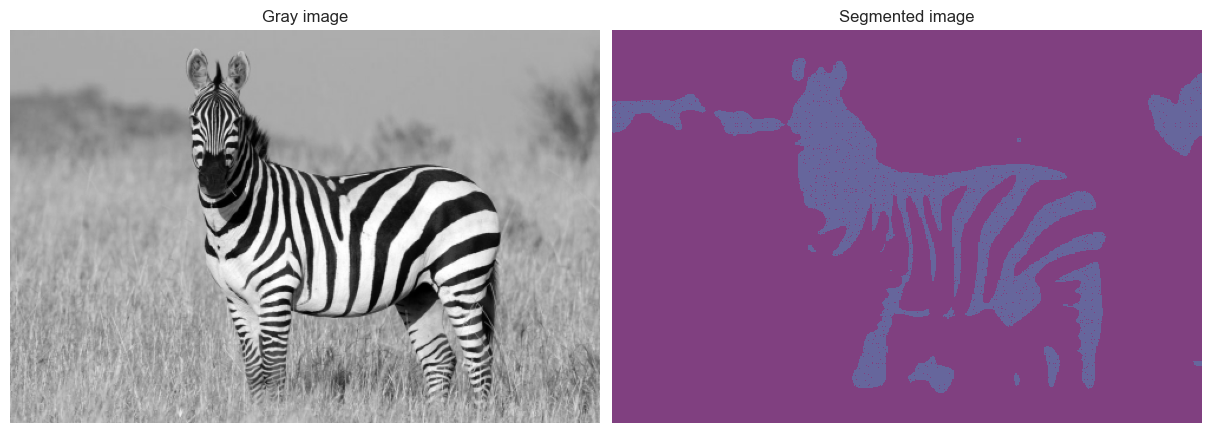

Wall time: 1.34 s


In [140]:
%%time
segment_image_gabor(img1_gray, scales=5, angles=8, ksize=71, lambd=31, gamma=0.5, psi=0, n_clusters=2, random_state=2, debug=True)


### Tiger

(5, 8, 130, 186)
(24180, 40)


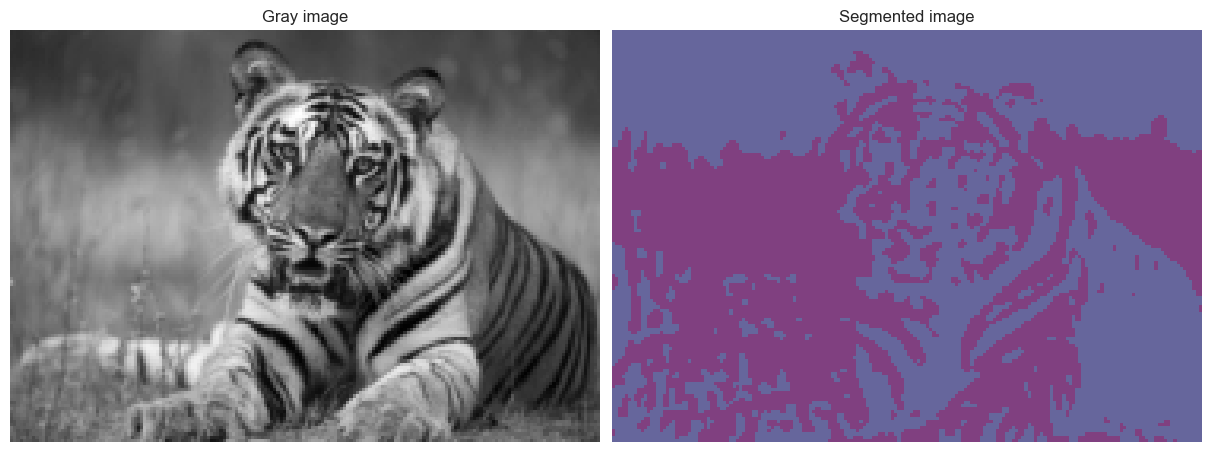

Wall time: 367 ms


In [141]:
%%time
segment_image_gabor(img2_gray, scales=5, angles=8, ksize=35, lambd=5, gamma=0.5, psi=0, n_clusters=2, random_state=2, debug=True)


(6, 8, 130, 186)
(24180, 48)


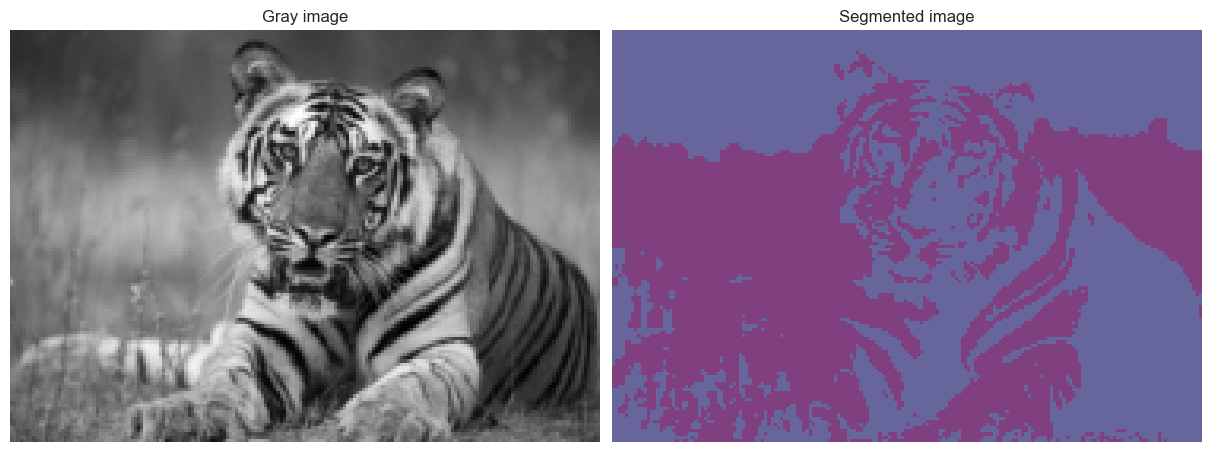

Wall time: 356 ms


In [142]:
%%time
segment_image_gabor(img2_gray, scales=6, angles=8, ksize=5, lambd=1, gamma=0.5, psi=0, n_clusters=2, random_state=2, debug=True)
